### Import of the required libraries

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTENC

from collections import Counter

from tensorflow import keras
import tensorflow_addons as tfad

### Load the data

In [2]:
data = pd.read_csv("./data/churn.csv")

## Feature Engineering

### Remove unused columns

In [4]:
data_prepared = data.drop(["RowNumber", "CustomerId", "Surname", "Exited"], axis=1)
y = data["Exited"]

data_prepared

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


### Create pipeline for scalling and one-hot encoding

In [5]:
scaler_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

In [6]:
onehot_pipeline = Pipeline([ 
    ("onehot", OneHotEncoder())
])

In [7]:
full_transformer = ColumnTransformer([
    ("pass", "passthrough", ["HasCrCard", "IsActiveMember"]),
    ("scaler", scaler_pipeline, ["Age", "CreditScore", "Balance", "EstimatedSalary", "Tenure", "NumOfProducts"]),
    ("onehot", onehot_pipeline, ["Geography", "Gender"])
])

### The last 500 records are for the validation set

In [92]:
data_final = data_prepared[:9500]
y_final = y[:9500]
 
data_validation = data_prepared[9500:]
y_validation = y[9500:]

### Splitting the dataset in data and label

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data_final, y_final, test_size=0.2, shuffle=True, random_state=42)

### Scaling and one-hot encoding of the dataset

In [110]:
X_train_onehot_scaled = full_transformer.fit_transform(X_train)
X_test_onehot_scaled = full_transformer.fit_transform(X_test)

print(X_train_onehot_scaled.shape)
print(X_test_onehot_scaled.shape)

pd.DataFrame(X_test_onehot_scaled)

(7600, 13)
(1900, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.0,2.538320,-0.793746,0.561044,1.546675,1.372788,-0.870232,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.933549,2.095289,0.836004,-0.572108,0.329886,-0.870232,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.555956,-0.607357,-1.234436,0.460153,-1.408284,-0.870232,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,-0.860018,1.121922,1.100939,-1.570825,-1.060650,-0.870232,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,-0.104832,-0.317418,-1.234436,-1.233121,0.677520,-0.870232,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,1.0,0.0,-0.293628,1.008017,-1.234436,-1.364090,1.372788,-0.870232,1.0,0.0,0.0,1.0,0.0
1896,0.0,1.0,-0.010433,-0.710906,-1.234436,-1.016056,-0.017748,0.825605,1.0,0.0,0.0,0.0,1.0
1897,1.0,1.0,1.405541,-0.597002,-1.234436,-0.090868,-0.365382,0.825605,1.0,0.0,0.0,1.0,0.0
1898,1.0,0.0,0.272761,0.096781,-0.567054,0.237821,-0.017748,-0.870232,0.0,0.0,1.0,0.0,1.0


### Oversampling the minority class
We need to do an oversampling because the exited class is underrepresented

In [256]:
oversampler = SMOTENC([0, 1, 8, 9, 10, 11, 12], random_state=42, sampling_strategy="auto", k_neighbors=2)
X_train_resample, y_train_resample = oversampler.fit_resample(X_train_onehot_scaled, y_train)

print(Counter(y_train_resample))
print(X_train_resample.shape)
print(y_train_resample.shape)

Counter({0: 6055, 1: 6055})
(12110, 13)
(12110,)


## Train the Neuronal Network

In [315]:
def create_model(lr=0.0002):
    nn_model = keras.models.Sequential([
        keras.layers.Input(shape=X_train_resample[-1].shape),
        keras.layers.Dense(64, activation=keras.activations.relu,
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(32, activation=keras.activations.relu,
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(16, activation=keras.activations.relu,
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(8, activation=keras.activations.relu,
                            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(1, activation=keras.activations.sigmoid,
                            kernel_regularizer=keras.regularizers.l2(0.01))
    ])

    nn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        loss=keras.losses.BinaryCrossentropy(), 
        metrics=["accuracy"])

    return nn_model

In [297]:
nn_model = create_model()
history = nn_model.fit(X_train_resample, y_train_resample, validation_data=(X_test_onehot_scaled, y_test), epochs=25)

Epoch 1/25
379/379 [==============================] - 1s 2ms/step - loss: 1.4242 - accuracy: 0.6296 - val_loss: 1.2609 - val_accuracy: 0.6374
Epoch 2/25
379/379 [==============================] - 1s 2ms/step - loss: 1.0462 - accuracy: 0.7437 - val_loss: 0.9492 - val_accuracy: 0.7500
Epoch 3/25
379/379 [==============================] - 1s 1ms/step - loss: 0.8377 - accuracy: 0.7586 - val_loss: 0.7884 - val_accuracy: 0.7642
Epoch 4/25
379/379 [==============================] - 1s 1ms/step - loss: 0.7314 - accuracy: 0.7693 - val_loss: 0.7219 - val_accuracy: 0.7626
Epoch 5/25
379/379 [==============================] - 1s 2ms/step - loss: 0.6756 - accuracy: 0.7763 - val_loss: 0.6831 - val_accuracy: 0.7658
Epoch 6/25
379/379 [==============================] - 1s 2ms/step - loss: 0.6456 - accuracy: 0.7776 - val_loss: 0.6249 - val_accuracy: 0.7958
Epoch 7/25
379/379 [==============================] - 1s 1ms/step - loss: 0.6273 - accuracy: 0.7780 - val_loss: 0.6195 - val_accuracy: 0.7905
Epoch 

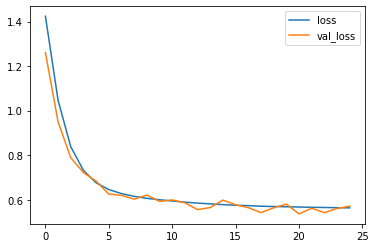

In [298]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

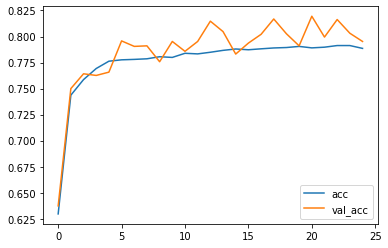

In [299]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Predict the validation dataset

In [300]:
X_validation_onehot_scaled = full_transformer.fit_transform(data_validation)
X_validation_onehot_scaled.shape

(500, 13)

In [301]:
prediction = nn_model.predict(X_validation_onehot_scaled).ravel() > 0.5
y_pred = [int(p) for p in prediction]

In [302]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       413
           1       0.44      0.79      0.57        87

    accuracy                           0.79       500
   macro avg       0.69      0.79      0.71       500
weighted avg       0.86      0.79      0.81       500



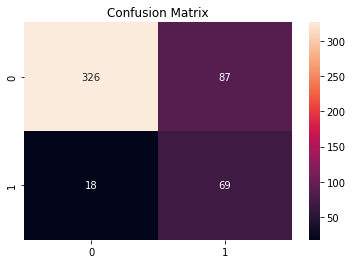

In [303]:
con_matrix = confusion_matrix(y_validation, y_pred)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

## Train the Neuronal Network with k-fold

In [304]:
input_data = np.concatenate((X_train_resample, X_test_onehot_scaled), axis=0)
input_target = np.concatenate((y_train_resample, y_test), axis=0)

print(input_data.shape)
print(input_target.shape)

(14010, 13)
(14010,)


In [305]:
fold_number = 1
models = list()
kfold = KFold(n_splits=10, shuffle=True)

for train, test in kfold.split(input_data, input_target):
    nn_model = create_model()

    print(f"Training for fold {fold_number}")
    history = nn_model.fit(input_data[train], input_target[train], epochs=25, verbose=0)

    scores = nn_model.evaluate(input_data[test], input_target[test], verbose=0)
    print(f'Score for fold {fold_number}: {nn_model.metrics_names[0]} of {scores[0]}; {nn_model.metrics_names[1]} of {scores[1] * 100}%')

    models.append({"model": nn_model, "loss": scores[0]})
    fold_number += 1

Training for fold 1
Score for fold 1: loss of 0.5635166764259338; accuracy of 79.01498675346375%
Training for fold 2
Score for fold 2: loss of 0.5785560607910156; accuracy of 77.80157327651978%
Training for fold 3
Score for fold 3: loss of 0.563678503036499; accuracy of 79.87151741981506%
Training for fold 4
Score for fold 4: loss of 0.5703551769256592; accuracy of 78.0870795249939%
Training for fold 5
Score for fold 5: loss of 0.5476114749908447; accuracy of 80.2997887134552%
Training for fold 6
Score for fold 6: loss of 0.5774945616722107; accuracy of 78.30121517181396%
Training for fold 7
Score for fold 7: loss of 0.549545168876648; accuracy of 79.65738773345947%
Training for fold 8
Score for fold 8: loss of 0.5659047961235046; accuracy of 79.08636927604675%
Training for fold 9
Score for fold 9: loss of 0.5634819269180298; accuracy of 78.58672142028809%
Training for fold 10
Score for fold 10: loss of 0.5462281107902527; accuracy of 80.44254183769226%


In [306]:
best_model_dict = next(iter(sorted(models, key=lambda m: m["loss"])))
best_model = best_model_dict["model"]

In [307]:
prediction = best_model.predict(X_validation_onehot_scaled).ravel() > 0.5
y_pred = [int(p) for p in prediction]

In [308]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.86       413
           1       0.45      0.78      0.57        87

    accuracy                           0.79       500
   macro avg       0.70      0.79      0.72       500
weighted avg       0.86      0.79      0.81       500



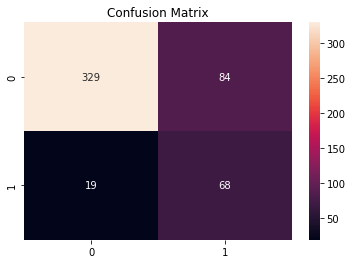

In [309]:
con_matrix = confusion_matrix(y_validation, y_pred)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

## Interpret the Neuronal Network Model

In [242]:
X_explain = pd.DataFrame(X_train_onehot_scaled, columns=["Age", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember", "CreditScore", "Balance", "EstimatedSalary", "Gender_Female", "Gender_Male", "Geography_Spain", "Geography_France", "Geography_Germany"])
X_explain.head()

,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,CreditScore,Balance,EstimatedSalary,Gender_Female,Gender_Male,Geography_Spain,Geography_France,Geography_Germany
0,1.0,1.0,2.975201,1.460868,-1.221618,1.250160,-0.687920,0.798311,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.774389,0.592245,0.802557,0.561141,-1.724437,0.798311,1.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.295951,0.581905,-1.221618,0.913659,1.730619,0.798311,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,-1.043673,-0.328080,-1.221618,-0.822402,-0.687920,0.798311,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.487326,-0.617621,0.594571,-1.718920,1.730619,-0.923358,0.0,1.0,0.0,1.0,0.0


In [310]:
def f(X):
    return nn_model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

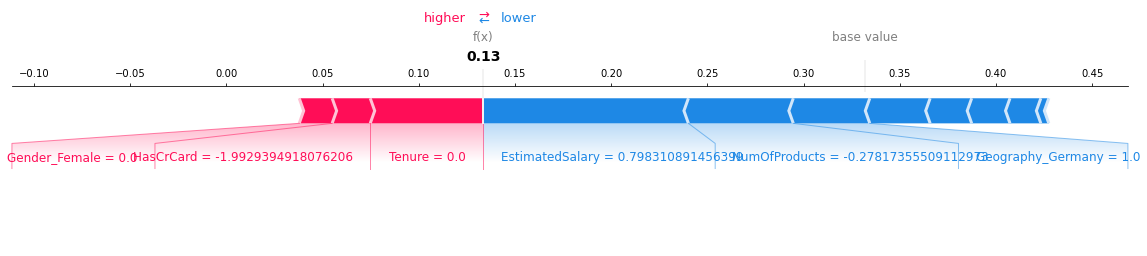

In [311]:
shap.initjs()
explainer = shap.KernelExplainer(nn_model, X_explain.iloc[:50])
shap_values = explainer.shap_values(X_explain.iloc[299,:], nsamples=500)

shap.force_plot(explainer.expected_value, shap_values[0], X_explain.iloc[299,:], matplotlib=True)

In [238]:
shap_values50 = explainer.shap_values(X_explain.iloc[280:330,:], nsamples=500)
plot = shap.force_plot(explainer.expected_value, shap_values50[0], X_explain.iloc[280:330,:])

shap.save_html('multivalue_force_plot.html', plot)

100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


## Train a Neuronal Network with cycling learning rate

In [337]:
steps_per_epoch = 2 * len(X_train_resample)
cyclical_learning_rate = tfad.optimizers.CyclicalLearningRate(
    initial_learning_rate=3e-6, 
    maximal_learning_rate=3e-5,
    step_size=steps_per_epoch,
    scale_fn=lambda x: 1 / (2.0 ** (x -1)),
    scale_mode="cycle"
)

In [341]:
nn_model = create_model(lr=cyclical_learning_rate)
history = nn_model.fit(X_train_resample, y_train_resample, validation_data=(X_test_onehot_scaled, y_test), epochs=80)

Epoch 1/80
379/379 [==============================] - 1s 2ms/step - loss: 1.7170 - accuracy: 0.4880 - val_loss: 1.7979 - val_accuracy: 0.2163
Epoch 2/80
379/379 [==============================] - 1s 1ms/step - loss: 1.7038 - accuracy: 0.4861 - val_loss: 1.7759 - val_accuracy: 0.2195
Epoch 3/80
379/379 [==============================] - 1s 2ms/step - loss: 1.6897 - accuracy: 0.4844 - val_loss: 1.7530 - val_accuracy: 0.2284
Epoch 4/80
379/379 [==============================] - 1s 2ms/step - loss: 1.6748 - accuracy: 0.4875 - val_loss: 1.7296 - val_accuracy: 0.2405
Epoch 5/80
379/379 [==============================] - 1s 2ms/step - loss: 1.6590 - accuracy: 0.4913 - val_loss: 1.7057 - val_accuracy: 0.2626
Epoch 6/80
379/379 [==============================] - 1s 2ms/step - loss: 1.6424 - accuracy: 0.5021 - val_loss: 1.6813 - val_accuracy: 0.3084
Epoch 7/80
379/379 [==============================] - 1s 2ms/step - loss: 1.6251 - accuracy: 0.5236 - val_loss: 1.6568 - val_accuracy: 0.3605
Epoch 

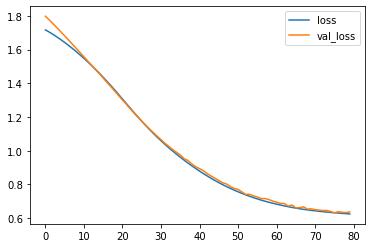

In [342]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

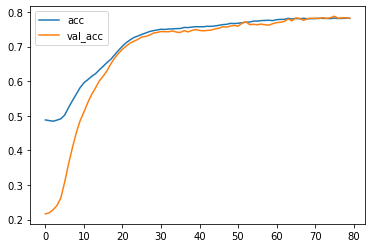

In [343]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [344]:
prediction = nn_model.predict(X_validation_onehot_scaled).ravel() > 0.5
y_pred = [int(p) for p in prediction]

In [345]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       413
           1       0.40      0.76      0.52        87

    accuracy                           0.76       500
   macro avg       0.67      0.76      0.68       500
weighted avg       0.84      0.76      0.78       500



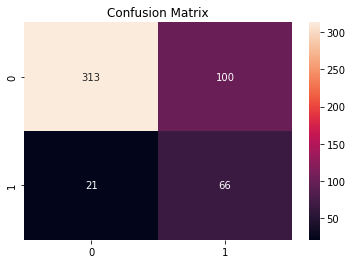

In [346]:
con_matrix = confusion_matrix(y_validation, y_pred)
sns.heatmap(con_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()